In [3]:
import copy
import cv2
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

In [51]:
deepfakes_df = pd.read_csv("../dataset/deepfakes_train_test_val_2.csv", index_col = 0)
#face2face_df = pd.read_csv("../dataset/face2face_train_test_val_2.csv", index_col = 0)
#faceswap_df = pd.read_csv("../dataset/faceswap_train_test_val_2.csv", index_col = 0)
neuraltextures_df = pd.read_csv("../dataset/neuraltextures_train_test_val_2.csv", index_col = 0)

In [96]:
# deepfakes_df=0
# face2face_df=0
# faceswap_df = 0
# neuraltextures_df = 0

In [5]:
real_youtube_df = pd.read_csv("../dataset/real_youtube_train_test_val.csv", index_col = 0)

In [97]:
all_df = pd.read_csv("../dataset/all_train_test_val.csv", index_col = 0)

In [6]:
import pickle

# with open(model_path, 'rb') as fin:
#     model = pickle.load(fin)
    
logit_f2f_path = "../ModelsPickle/logit_face2face.pickle"
lgbm_f2f_path =  "../ModelsPickle/lgbm_face2face_updated.pickle"

logit_fs_path = "../ModelsPickle/logit_faceswap.pickle"
lgbm_fs_path = "../ModelsPickle/lgbm_faceswap_updated.pickle"

logit_df_path = "../ModelsPickle/logit_deepfake.pickle"
lgbm_df_path = "../ModelsPickle/lgbm_deepfakes_updated.pickle"

logit_nt_path = "../ModelsPickle/logit_neuraltextures.pickle"
lgbm_nt_path = "../ModelsPickle/lgbm_neuraltextures_updated.pickle"

logit_all_path = "../ModelsPickle/logit_all.pickle"
lgbm_all_path = "../ModelsPickle/lgbm_all_updated.pickle"



In [7]:
model_path = logit_f2f_path
with open(model_path, 'rb') as fin:
    logit_f2f = pickle.load(fin)

In [8]:
model_path = logit_fs_path
with open(model_path, 'rb') as fin:
    logit_fs = pickle.load(fin)

In [9]:
model_path = logit_df_path
with open(model_path, 'rb') as fin:
    logit_df = pickle.load(fin)

In [10]:
model_path = logit_nt_path
with open(model_path, 'rb') as fin:
    logit_nt = pickle.load(fin)

In [11]:
model_path = logit_all_path
with open(model_path, 'rb') as fin:
    logit_all = pickle.load(fin)

In [11]:
#!pip install lightgbm

In [21]:
model_path = lgbm_f2f_path
with open(model_path, 'rb') as fin:
    lgbm_f2f = pickle.load(fin)

In [22]:
model_path = lgbm_fs_path
with open(model_path, 'rb') as fin:
    lgbm_fs = pickle.load(fin)

In [23]:
model_path = lgbm_df_path
with open(model_path, 'rb') as fin:
    lgbm_df = pickle.load(fin)

In [24]:
model_path = lgbm_nt_path
with open(model_path, 'rb') as fin:
    lgbm_nt = pickle.load(fin)

In [25]:
model_path = lgbm_all_path
with open(model_path, 'rb') as fin:
    lgbm_all = pickle.load(fin)

In [12]:
def shuffle_two_arrays(arr1, arr2):
    shuffler = np.random.permutation(len(arr1))
    array1_shuffled = arr1[shuffler]
    array2_shuffled = arr2[shuffler]

    return array1_shuffled, array2_shuffled

def demeaning_local(array_nd):
    array_nd = array_nd.astype('float32')
    means = array_nd.mean(axis=(0,1,2), dtype='float64')
    #print('Means: %s' % means)
    #print(means.shape)
    array_nd -= means
    return array_nd

In [13]:
def get_x_y_test(fake_df, real_df):
    fake_test = fake_df[fake_df['train_fixed'] == 'test']
    real_test = real_df[real_df['train'] == 'test']
    x_test = np.concatenate((fake_test.iloc[:,:-3].values, real_test.iloc[:,:-2].values), axis=0)
    y_test = np.concatenate((np.ones(fake_test.shape[0]), np.zeros(real_test.shape[0])))
    x_test, y_test = shuffle_two_arrays(x_test, y_test)
    x_test_4d = np.reshape(x_test, (x_test.shape[0],40,40,4,3))
    x_test_4d_demean = demeaning_local(x_test_4d)
    x_test_flat = x_test_4d_demean.reshape((x_test.shape[0], 40*40*4*3))
    return x_test_flat, y_test

In [100]:
def get_x_y_test_all(fake_df, real_df):
    fake_test = fake_df[fake_df['train'] == 'test']
    real_test = real_df[real_df['train'] == 'test']
    x_test = np.concatenate((fake_test.iloc[:,:-3].values, real_test.iloc[:,:-3].values), axis=0)
    y_test = np.concatenate((np.ones(fake_test.shape[0]), np.zeros(real_test.shape[0])))
    x_test, y_test = shuffle_two_arrays(x_test, y_test)
    x_test_4d = np.reshape(x_test, (x_test.shape[0],40,40,4,3))
    x_test_4d_demean = demeaning_local(x_test_4d)
    x_test_flat = x_test_4d_demean.reshape((x_test.shape[0], 40*40*4*3))
    return x_test_flat, y_test

In [98]:
def get_x_y_test_lgbm(fake_df, real_df):
    fake_test = fake_df[fake_df['train'] == 'test']
    real_test = real_df[real_df['train'] == 'test']
    x_test = np.concatenate((fake_test.iloc[:,:-3].values, real_test.iloc[:,:-3].values), axis=0)
    y_test = np.concatenate((np.ones(fake_test.shape[0]), np.zeros(real_test.shape[0])))
    x_test, y_test = shuffle_two_arrays(x_test, y_test)

    return x_test, y_test

In [30]:
x_f2f_test, y_f2f_test = get_x_y_test(face2face_df, real_youtube_df)

In [31]:
x_f2f_test_lgbm, y_f2f_test_lgbm = get_x_y_test_lgbm(face2face_df, real_youtube_df)

In [32]:
print(x_f2f_test.shape, y_f2f_test.shape)
print(x_f2f_test_lgbm.shape, y_f2f_test_lgbm.shape)

(3293, 19200) (3293,)
(3292, 19200) (3292,)


In [91]:
x_fs_test, y_fs_test = get_x_y_test(faceswap_df, real_youtube_df)

In [92]:
x_fs_test_lgbm, y_fs_test_lgbm = get_x_y_test_lgbm(faceswap_df, real_youtube_df)

In [52]:
x_df_test, y_df_test = get_x_y_test(deepfakes_df, real_youtube_df)
x_df_test_lgbm, y_df_test_lgbm = get_x_y_test_lgbm(deepfakes_df, real_youtube_df)

In [53]:
x_nt_test, y_nt_test = get_x_y_test(neuraltextures_df, real_youtube_df)
x_nt_test_lgbm, y_nt_test_lgbm = get_x_y_test_lgbm(neuraltextures_df, real_youtube_df)

In [26]:
face2face_df = 0
faceswap_df = 0
deepfakes_df = 0

neuraltextures_df = 0 

In [101]:
fake_all_df = all_df[all_df['label'] == 1]
real_all_df = all_df[all_df['label'] == 0]

x_all_test, y_all_test = get_x_y_test_all(fake_all_df, real_all_df)
x_all_test_lgbm, y_all_test_lgbm = get_x_y_test_lgbm(fake_all_df, real_all_df)

In [33]:
y_f2f_pred_logit = logit_f2f.predict_proba(x_f2f_test)

In [34]:
y_f2f_pred_lgbm = lgbm_f2f.predict(x_f2f_test_lgbm)

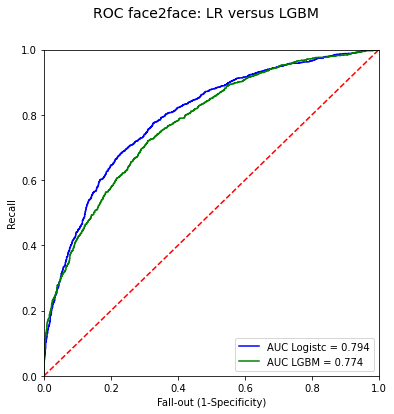

In [45]:
from sklearn.metrics import roc_curve, auc
plt.figure(figsize = (6, 6))
y_f2f_probs_logit = y_f2f_pred_logit[:, 1]
false_positive_rate, recall, thresholds = roc_curve(y_f2f_test, y_f2f_probs_logit) 
roc_auc = auc(false_positive_rate, recall)
false_positive_rate2, recall2, thresholds2 = roc_curve(y_f2f_test_lgbm, y_f2f_pred_lgbm) 
roc_auc2 = auc(false_positive_rate2, recall2)
plt.suptitle('ROC {}: {} versus {}'.format('face2face','LR', 'LGBM'),  fontsize=14)
plt.plot(false_positive_rate, recall, 'b', label = 'AUC Logistc = %0.3f' %roc_auc)
plt.plot(false_positive_rate2, recall2, 'g', label = 'AUC LGBM = %0.3f' %roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

In [46]:
face2face_df = 0

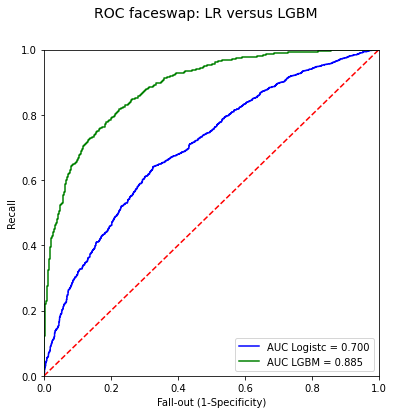

In [50]:
y_fs_pred_logit = logit_fs.predict_proba(x_fs_test)

y_fs_pred_lgbm = lgbm_fs.predict(x_fs_test_lgbm)

from sklearn.metrics import roc_curve, auc
plt.figure(figsize = (6, 6))
y_fs_probs_logit = y_fs_pred_logit[:, 1]
false_positive_rate, recall, thresholds = roc_curve(y_fs_test, y_fs_probs_logit) 
roc_auc = auc(false_positive_rate, recall)
false_positive_rate2, recall2, thresholds2 = roc_curve(y_fs_test_lgbm, y_fs_pred_lgbm) 
roc_auc2 = auc(false_positive_rate2, recall2)
plt.suptitle('ROC {}: {} versus {}'.format('faceswap','LR', 'LGBM'),  fontsize=14)
plt.plot(false_positive_rate, recall, 'b', label = 'AUC Logistc = %0.3f' %roc_auc)
plt.plot(false_positive_rate2, recall2, 'g', label = 'AUC LGBM = %0.3f' %roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

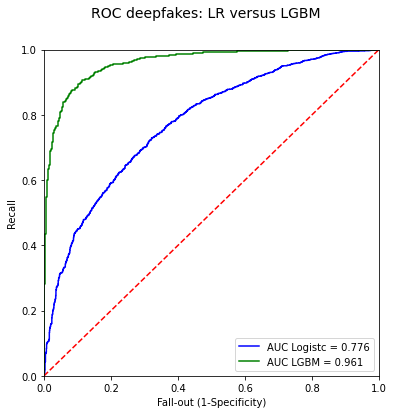

In [57]:
x_fs_test = x_df_test
x_fs_test_lgbm = x_df_test_lgbm
y_fs_test = y_df_test
y_fs_test_lgbm = y_df_test_lgbm


x_df_test, y_df_test = get_x_y_test(deepfakes_df, real_youtube_df)
x_df_test_lgbm, y_df_test_lgbm = get_x_y_test_lgbm(deepfakes_df, real_youtube_df)

y_df_pred_logit = logit_df.predict_proba(x_df_test)

y_df_pred_lgbm = lgbm_df.predict(x_df_test_lgbm)

from sklearn.metrics import roc_curve, auc
plt.figure(figsize = (6, 6))
y_df_probs_logit = y_df_pred_logit[:, 1]
false_positive_rate, recall, thresholds = roc_curve(y_df_test, y_df_probs_logit) 
roc_auc = auc(false_positive_rate, recall)
false_positive_rate2, recall2, thresholds2 = roc_curve(y_df_test_lgbm, y_df_pred_lgbm) 
roc_auc2 = auc(false_positive_rate2, recall2)
plt.suptitle('ROC {}: {} versus {}'.format('deepfakes','LR', 'LGBM'),  fontsize=14)
plt.plot(false_positive_rate, recall, 'b', linewidth = 3, label = 'AUC Logistc = %0.3f' %roc_auc)
plt.plot(false_positive_rate2, recall2, 'g', linewidth = 3, label = 'AUC LGBM = %0.3f' %roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--', linewidth = 1)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

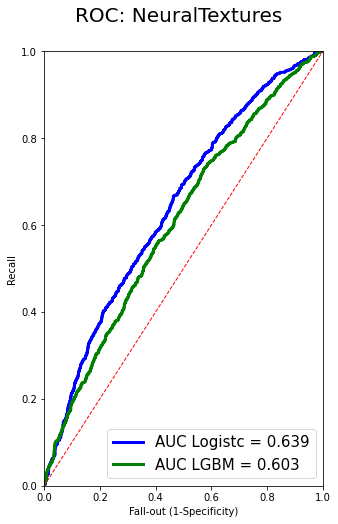

In [85]:
y_nt_pred_logit = logit_nt.predict_proba(x_nt_test)

y_nt_pred_lgbm = lgbm_nt.predict(x_nt_test_lgbm)




from matplotlib import rcParams
rcParams['axes.titlepad'] = 8


from sklearn.metrics import roc_curve, auc
plt.figure(figsize = (5, 8))
y_nt_probs_logit = y_nt_pred_logit[:, 1]
false_positive_rate, recall, thresholds = roc_curve(y_nt_test, y_nt_probs_logit) 
roc_auc = auc(false_positive_rate, recall)
false_positive_rate2, recall2, thresholds2 = roc_curve(y_nt_test_lgbm, y_nt_pred_lgbm) 
roc_auc2 = auc(false_positive_rate2, recall2)
plt.suptitle('ROC: {}'.format('NeuralTextures'),  fontsize=20, y = 0.957)
plt.plot(false_positive_rate, recall, 'b', linewidth = 3, label = 'AUC Logistc = %0.3f' %roc_auc)
plt.plot(false_positive_rate2, recall2, 'g', linewidth = 3, label = 'AUC LGBM = %0.3f' %roc_auc2)
plt.legend(loc='lower right', prop={'size': 15})
plt.plot([0,1], [0,1], 'r--', linewidth = 1)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

In [88]:
def draw_AUC_plot(logit_nt, lgbm_nt, x_nt_test, x_nt_test_lgbm, y_nt_test, y_nt_test_lgbm, fakename):
    plt.figure(figsize = (5, 8))
    y_nt_pred_logit = logit_nt.predict_proba(x_nt_test)

    y_nt_pred_lgbm = lgbm_nt.predict(x_nt_test_lgbm)
    y_nt_probs_logit = y_nt_pred_logit[:, 1]
    false_positive_rate, recall, thresholds = roc_curve(y_nt_test, y_nt_probs_logit) 
    roc_auc = auc(false_positive_rate, recall)
    false_positive_rate2, recall2, thresholds2 = roc_curve(y_nt_test_lgbm, y_nt_pred_lgbm) 
    roc_auc2 = auc(false_positive_rate2, recall2)
    plt.suptitle('ROC: {}'.format(fakename),  fontsize=20, y = 0.957)
    plt.plot(false_positive_rate, recall, 'b', linewidth = 3, label = 'AUC Logistc = %0.3f' %roc_auc)
    plt.plot(false_positive_rate2, recall2, 'g', linewidth = 3, label = 'AUC LGBM = %0.3f' %roc_auc2)
    plt.legend(loc='lower right', prop={'size': 15})
    plt.plot([0,1], [0,1], 'r--', linewidth = 1)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.ylabel('Recall')
    plt.xlabel('Fall-out (1-Specificity)')
    plt.show()

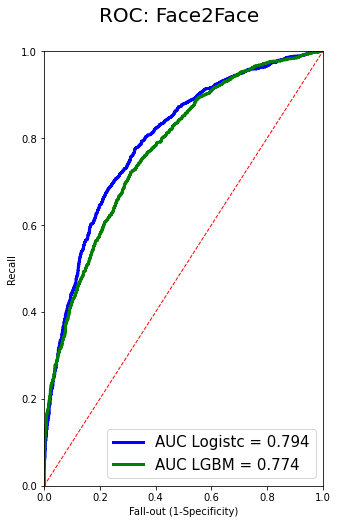

In [89]:
draw_AUC_plot(logit_f2f, lgbm_f2f, x_f2f_test, x_f2f_test_lgbm, y_f2f_test, y_f2f_test_lgbm, 'Face2Face')

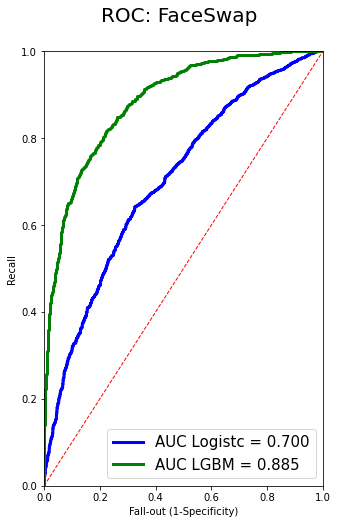

In [93]:
draw_AUC_plot(logit_fs, lgbm_fs, x_fs_test, x_fs_test_lgbm, y_fs_test, y_fs_test_lgbm, 'FaceSwap')

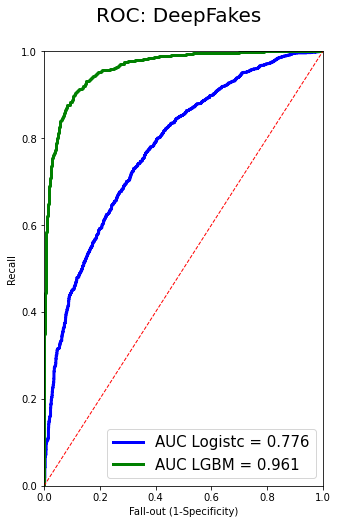

In [94]:
draw_AUC_plot(logit_df, lgbm_df, x_df_test, x_df_test_lgbm, y_df_test, y_df_test_lgbm, 'DeepFakes')

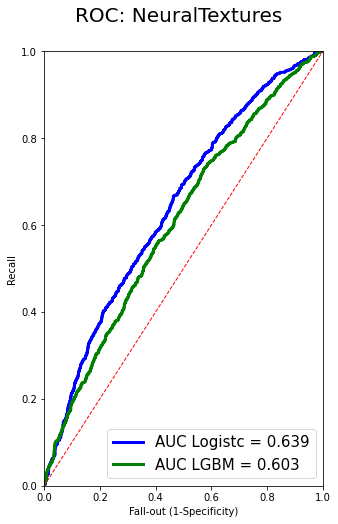

In [95]:
draw_AUC_plot(logit_nt, lgbm_nt, x_nt_test, x_nt_test_lgbm, y_nt_test, y_nt_test_lgbm, 'NeuralTextures')

In [115]:
def draw_AUC_plot_all(logit_nt, lgbm_nt, x_nt_test, x_nt_test_lgbm, y_nt_test, y_nt_test_lgbm, fakename):
    plt.figure(figsize = (10, 10))
    y_nt_pred_logit = logit_nt.predict_proba(x_nt_test)

    y_nt_pred_lgbm = lgbm_nt.predict(x_nt_test_lgbm)
    y_nt_probs_logit = y_nt_pred_logit[:, 1]
    false_positive_rate, recall, thresholds = roc_curve(y_nt_test, y_nt_probs_logit) 
    roc_auc = auc(false_positive_rate, recall)
    false_positive_rate2, recall2, thresholds2 = roc_curve(y_nt_test_lgbm, y_nt_pred_lgbm) 
    roc_auc2 = auc(false_positive_rate2, recall2)
    plt.suptitle('ROC: {}'.format(fakename),  fontsize=25, y = 0.957)
    plt.plot(false_positive_rate, recall, 'b', linewidth = 3, label = 'AUC Logistic = %0.3f' %roc_auc)
    plt.plot(false_positive_rate2, recall2, 'g', linewidth = 3, label = 'AUC LGBM = %0.3f' %roc_auc2)
    plt.legend(loc='lower right', prop={'size': 22})
    plt.plot([0,1], [0,1], 'r--', linewidth = 1)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.ylabel('Recall')
    plt.xlabel('Fall-out (1-Specificity)')
    plt.show()

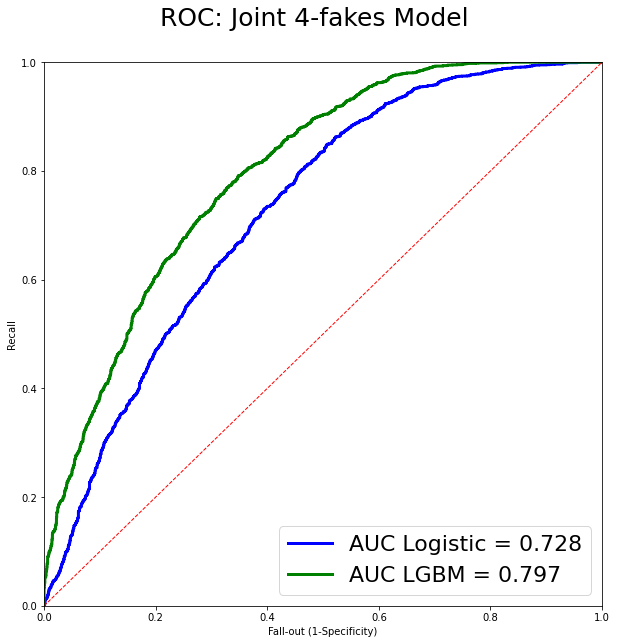

In [116]:
draw_AUC_plot_all(logit_all, lgbm_all, x_all_test, x_all_test_lgbm, y_all_test, y_all_test_lgbm, 'Joint 4-fakes Model')